## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [ ]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [279]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
from datetime import datetime
import datetime
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    # If using Mac M1/M2
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [3]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [4]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [5]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [6]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [7]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [8]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [9]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [10]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))
    
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [149]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [150]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [188]:
EMBEDDING_SIZE = 50
NEURONS = 75
LAYERS = 3
NUM_CLASSES = 4

In [189]:
class RnnModel(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        
        self._vars = {
            'embed_size': embed_size,
            'layers': layers,
            'hidden': hidden,
            'classes': num_classes
        }
        
        self.embedding_layer = nn.Embedding(
            num_embeddings=len(vocab), 
            embedding_dim=embed_size
        )
        
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True) 
        self.fc = nn.Linear(hidden, num_classes) 
        
    def forward(self, x):
        batch_size = len(x)
        embeddings = self.embedding_layer(x)
        hidden = torch.randn(self._vars['layers'], batch_size, self._vars['hidden']).to(device=device)
        carry = torch.randn(self._vars['layers'], batch_size, self._vars['hidden']).to(device=device)
        output, (hidden, carry) = self.rnn(embeddings, (hidden, carry))
        output = self.fc(output[:,-1])
        return output

embed_len = 50
hidden_dim = 75
n_layers=3

In [190]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for mb, (xi, yi) in enumerate(loader):
            xi = xi.to(device=device, dtype = torch.long)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            cost += (F.cross_entropy(scores, yi)).item()
            _, pred = scores.max(dim=1) 
            num_correct += (torch.argmax(scores, dim=1) == yi.squeeze()).sum()
            num_total += pred.size(0)

    return cost/mb, float(num_correct)/num_total

In [192]:
def train(model, optimizer, epochs=100):
    model = model.to(device=device)
    train_cost = 0.
    val_cost = 0.
    
    print("## Total number of batches: {}".format(len(train_loader)))
    
    last_batch_time = 1
    remaining_epochs = epochs
    batches = len(train_loader)
    
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        train_correct_num  = 0.
        train_total = 0.
        train_cost_acum = 0
        remaining_batches = batches
        for mb, (xi, yi) in enumerate(train_loader):
            print("\r## Epoch {}/{} ..... Batch {}/{} ..... Epoch ETA {} ..... Training ETA {}".format(
                epoch + 1, 
                epochs, 
                mb + 1, 
                batches,
                datetime.timedelta(
                    seconds=int(remaining_batches * last_batch_time)
                ),
                datetime.timedelta(
                    seconds=int(
                        (remaining_batches * last_batch_time) + ((remaining_epochs - 1) * batches * last_batch_time)
                    )
                )
            ), end="")
            t1 = time.time()
            model.train()
            xi = xi.to(device=device, dtype=torch.long)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = loss_fn(input=scores, target=yi)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            train_correct_num += (torch.argmax(scores, dim=1) == yi).sum()
            train_total += scores.size(0)

            train_cost_acum += cost.item() 
            t2 = time.time()
            last_batch_time = t2 - t1
            remaining_batches -= 1

        val_cost, val_acc = accuracy(model, val_loader)
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/mb
        remaining_epochs -= 1
        
        print("\r## Epoch {}/{} ... Train Cost {:.6f} ... Val Cost {:.6f} ... Train Acc {:.6f} ... Val Acc {:.6f}".format(
            epoch + 1, epochs,
            train_cost, val_cost,
            train_acc, val_acc
        ))

In [193]:
epochs = 20
lr = 1e-3
rnn_model = RnnModel(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


In [194]:
train(rnn_model, optimizer=optimiser,  epochs=epochs)

## Total number of batches: 422
## Epoch 1/20 ... Train Cost 1.017834 ... Val Cost 0.627491 ... Train Acc 0.526167 ... Val Acc 0.770667
## Epoch 2/20 ... Train Cost 0.483795 ... Val Cost 0.422525 ... Train Acc 0.825657 ... Val Acc 0.855333
## Epoch 3/20 ... Train Cost 0.349301 ... Val Cost 0.369166 ... Train Acc 0.880907 ... Val Acc 0.877083
## Epoch 4/20 ... Train Cost 0.286718 ... Val Cost 0.344592 ... Train Acc 0.904074 ... Val Acc 0.887917
## Epoch 5/20 ... Train Cost 0.245386 ... Val Cost 0.321941 ... Train Acc 0.918657 ... Val Acc 0.893667
## Epoch 6/20 ... Train Cost 0.212532 ... Val Cost 0.321253 ... Train Acc 0.930028 ... Val Acc 0.895833
## Epoch 7/20 ... Train Cost 0.185550 ... Val Cost 0.324158 ... Train Acc 0.939824 ... Val Acc 0.898000
## Epoch 8/20 ... Train Cost 0.162700 ... Val Cost 0.317591 ... Train Acc 0.948213 ... Val Acc 0.899083
## Epoch 9/20 ... Train Cost 0.142527 ... Val Cost 0.323517 ... Train Acc 0.954954 ... Val Acc 0.902417
## Epoch 10/20 ... Train Cost 0.

In [196]:
print(f'{accuracy(rnn_model, test_loader)[1]:.4f}')

0.8941


In [246]:
def get_class(x:int):
    if x == 0:
        return "World"
    elif x == 1:
        return "Sports"
    elif x == 2:
        return "Business"
    elif x == 3:
        return "Sci/Tech"
    else:
        return "Unknown"


def sample_text(model, loader):
    idx = np.random.randint(len(test_loader))
    print("Text:", loader.dataset[idx][1])
    print()
    _words = tokeniser(loader.dataset[idx][1])
    _tokens = vocab(_words)
    _tensor = torch.tensor([_tokens]).to(device=device)
    scores = model(_tensor)
    _prediction = torch.argmax(scores, dim=1)[0].item()
    print("Predicted class: ", get_class(_prediction))
    print("Actual class:", get_class(loader.dataset[idx][0] - 1))

In [262]:
sample_text(rnn_model, test_loader)

Text: Tougher rules won't soften Law's game FOXBOROUGH -- Looking at his ridiculously developed upper body, with huge biceps and hardly an ounce of fat, it's easy to see why Ty Law, arguably the best cornerback in football, chooses physical play over finesse. That's not to imply that he's lacking a finesse component, because he can shut down his side of the field much as Deion Sanders ...

Predicted class:  Sports
Actual class: Sports


In [276]:
def predict(model, loader):
    y_pred = []
    y_real = []

    model.eval()
    model = model.to(device=device)

    for xi, yi in loader:
        with torch.no_grad():
            xi = xi.to(device=device, dtype=torch.long)
            scores = model(xi)
            pred = torch.argmax(scores, dim=1)
            y_pred.extend(pred.tolist())
            y_real.extend(yi.tolist())

    return y_real, y_pred

def create_confusion_matrix(model, loader):
    y_real, y_pred = predict(model, loader)

    return confusion_matrix(y_real, y_pred)
    
create_confusion_matrix(rnn_model, test_loader)

array([[1705,   44,   86,   65],
       [  32, 1818,   23,   27],
       [  62,   22, 1632,  184],
       [  48,   23,  175, 1654]], dtype=int64)

In [285]:
def plot_confusion_matrix(model, loader, normalize=None):
    y_real, y_pred = predict(model, loader)
    ConfusionMatrixDisplay.from_predictions(
        y_real, 
        y_pred,
        cmap=mpl.colormaps['Blues'],
        display_labels=['World', 'Sports', 'Business', 'Sci/Tech'],
        normalize=normalize
    )
    plt.show()

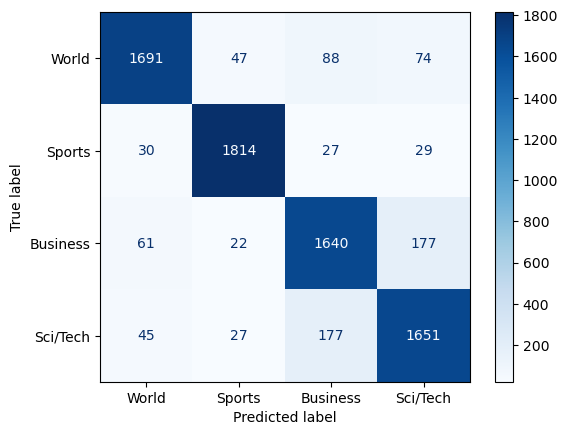

In [288]:
plot_confusion_matrix(rnn_model, test_loader)

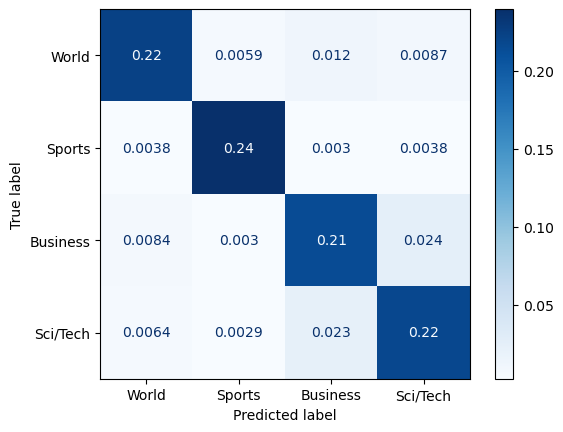

In [289]:
plot_confusion_matrix(rnn_model, test_loader, normalize='all')